In [5]:
import glob
import os
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.metrics import precision_recall_fscore_support
from datetime import datetime

In [7]:
# データ読み込み
import urbansound8k_loader as dataset

#parent_dir = 'UrbanSound8K/audio/'
#tr_features, tr_labels = dataset.load_urbansound8k(parent_dir, ['fold1', 'fold2'])
#ts_features, ts_labels = dataset.load_urbansound8k(parent_dir, ['fold3'])

%time tr_features, tr_labels, ts_features, ts_labels = dataset.load_from_npy_files()

if (len(tr_features) !=  len(tr_labels)):
    print('WARN: invalid # of training data. features=' + str(len(tr_features)) + ', labels=' + str(len(tr_labels)))
elif (len(ts_features) !=  len(ts_labels)):
    print('WARN: invalid # of tast data. features=' + str(len(ts_features)) + ', labels=' + str(len(ts_labels)))
elif (len(tr_features) == 0 or len(ts_features) == 0):
    print('WARN: no data.')
else: 
    print('loaded successfully. # of train data=' + str(len(tr_features)) + ', # of test data=' + str(len(ts_features)))

CPU times: user 2.21 ms, sys: 5.91 ms, total: 8.11 ms
Wall time: 12.2 ms
loaded successfully. # of train data=1757, # of test data=1757


In [8]:
# 定数定義
training_epochs = 5000
n_dim = tr_features.shape[1]
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01
log_dir = './log'

In [9]:
# モデル構築
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

cost_function = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

2017/07/02 16:42:57
# of data=1757, epoches=5000
Test accuracy: 0.114
done. 2017/07/02 16:49:17


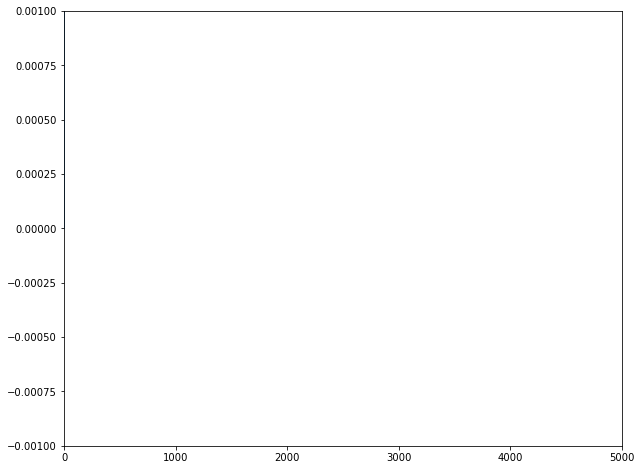

CPU times: user 1.44 ms, sys: 494 µs, total: 1.93 ms
Wall time: 1.81 ms
F-Score:0.114


In [11]:
# 学習、評価
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
print('# of data=' + str(len(tr_features)) + ', epoches=' + str(training_epochs))
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:tr_features,Y:tr_labels})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: ts_features})
    y_true = sess.run(tf.argmax(ts_labels,1))
    print('Test accuracy: ' + str(round(sess.run(accuracy, feed_dict={X: ts_features, Y: ts_labels}) , 3)))
    summary_op = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(log_dir, sess.graph)

print('done. ' + datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

%time p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:" + str(round(f,3)))